In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
plt.style.use(['seaborn','dracula'])
import bisect
from scipy.signal import butter, lfilter, freqz

In [2]:
def delay(signal, fs, dt):
    dt_star = int(dt)
    epsilon = dt-dt_star
    n = len(signal)
    t = np.linspace(0,(n-1)/fs,n)
    tmp_idx = bisect.bisect_left(t, dt)
    if tmp_idx > 0:
        if t[tmp_idx]-dt > dt - t[tmp_idx-1]:
            dt = t[tmp_idx-1]
        else:
            dt = t[tmp_idx]
    else:
        dt = t[tmp_idx]
    signal_fd = np.fft.fft(signal)
    w = 2*np.pi*fs*np.linspace(0,n-1,n)/n
    signal_fd *= np.exp(-1j*w*dt)
    signal_td = np.real(np.fft.ifft(signal_fd))
    signal_td[0:tmp_idx]=0.0
    return signal_td
    

In [4]:
npoint = (0.0,0.0) # (km,km) : ((0,12.6),(-7,7))
vr = 2.2 # km/s 
L = 8.4
W = 11.2
directory = './arkalochori_test'
nl = 3
nw = 5
r = 1.4
N = 2048
def create_signal(npoint,site):
    signal = {}
    signal['de'] = np.zeros((N,))
    signal['dn'] = np.zeros((N,))
    signal['dv'] = np.zeros((N,))
    signal['ve'] = np.zeros((N,))
    signal['vn'] = np.zeros((N,))
    signal['vv'] = np.zeros((N,))
    signal['ae'] = np.zeros((N,))
    signal['an'] = np.zeros((N,))
    signal['av'] = np.zeros((N,))
    signal['m0'] = 0
    nl = int(L/(2*r))
    nw = int(W/(2*r))
#     delays = np.zeros((nl,nw))
    file_no = 0
    for row in range(nl):
        for col in range(nw):
            filename = directory + '/' + site +  '_' + str(file_no) + '.npz'
            sgn = np.load(filename)
            if np.isnan(sgn['de'].sum())==1:
                print(file_no,row,col)
                file_no +=1
                continue
            center = (r + row * 2 * r, -W / 2 + r + col * 2 * r)
            d = np.sqrt((center[0] - npoint[0])**2 + (center[1] - npoint[1])**2)
            dly = d/vr
            aaa = 1.0
            if file_no in [10,11,5,6,0,1]:
#                 file_no += 1
#                 continue
                pass
            signal['de'] += aaa*delay(sgn['de'],N/40,dly)
            signal['dn'] += aaa*delay(sgn['dn'],N/40,dly)
            signal['dv'] += aaa*delay(sgn['dv'],N/40,dly)
            signal['ve'] += aaa*delay(sgn['ve'],N/40,dly)
            signal['vn'] += aaa*delay(sgn['vn'],N/40,dly)
            signal['vv'] += aaa*delay(sgn['vv'],N/40,dly)
            signal['ae'] += aaa*delay(sgn['ae'],N/40,dly)
            signal['an'] += aaa*delay(sgn['an'],N/40,dly)
            signal['av'] += aaa*delay(sgn['av'],N/40,dly)
            signal['m0'] += aaa*sgn['m0']
            file_no +=1
#     print(file_no)
    return signal



Text(0.5, 1.0, 'Displacement [cm] - UP / DOWN')

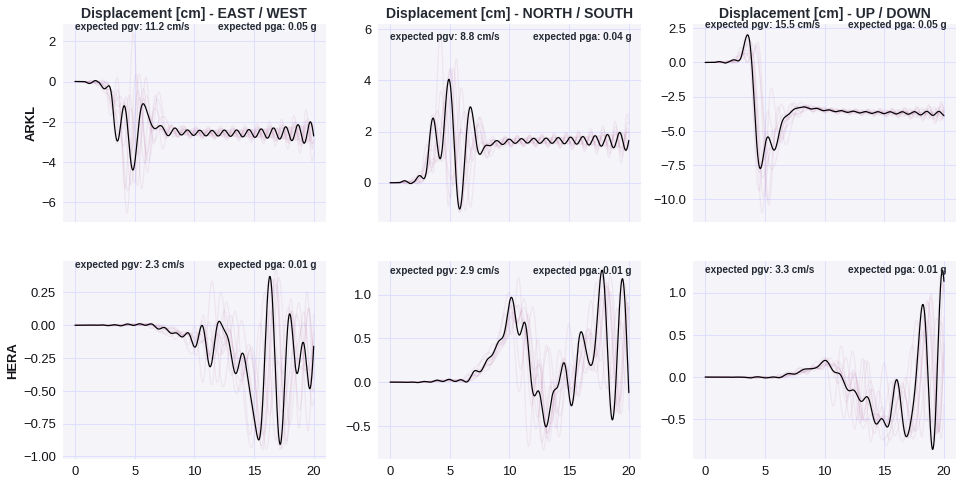

In [34]:
npoint = (0,0)
SITES = ['ARKL','HERA']
# SITES = ['PTR0','RIOA','TB4A','ARIA']
fig, axs = plt.subplots(2, 3, figsize=(16,8),sharex=True,sharey=False)
npoints = [(0,0)] # (dip-direction, strike-direction)
np.random.seed(10)
mean = [0, 0]
cov = [[1, 0], [0, 2]] 
sample_size = 10
x, y = np.random.multivariate_normal(mean, cov, sample_size).T
for idx, site in enumerate(SITES):
    pgve=0
    pgvn=0
    pgvv=0
    pgae=0
    pgan=0
    pgav=0
    axs[idx,0].set_ylabel(site, weight="bold")
    for npoint in zip(x+7.8,y):
        signal = create_signal(npoint,site)
        axs[idx,0].plot(np.linspace(0,20,2048),100*signal['de'],alpha=0.085,c='C3')
        axs[idx,1].plot(np.linspace(0,20,2048),100*signal['dn'],alpha=0.085,c='C3')
        axs[idx,2].plot(np.linspace(0,20,2048),100*signal['dv'],alpha=0.085,c='C3')
        pgve += 100*np.max(np.abs(signal['ve']))
        pgvn += 100*np.max(np.abs(signal['vn']))
        pgvv += 100*np.max(np.abs(signal['vv']))
        pgae += 100*np.max(np.abs(signal['ae']))/100/9.81
        pgan += 100*np.max(np.abs(signal['an']))/100/9.81
        pgav += 100*np.max(np.abs(signal['av']))/100/9.81
    signal = create_signal((7.8,0),site)
    axs[idx,0].plot(np.linspace(0,20,2048),100*signal['de'],alpha=1,c='black',lw=1.2)
    axs[idx,1].plot(np.linspace(0,20,2048),100*signal['dn'],alpha=1,c='black',lw=1.2)
    axs[idx,2].plot(np.linspace(0,20,2048),100*signal['dv'],alpha=1,c='black',lw=1.2)
    lowe, highe = axs[idx,0].get_ylim()
    lown, highn = axs[idx,1].get_ylim()
    lowv, highv = axs[idx,2].get_ylim()
    axs[idx,0].text(0,highe*0.9,'expected pgv: {:.1f} cm/s'.format(pgve/sample_size),weight="bold",fontsize='medium')
    axs[idx,1].text(0,highn*0.9,'expected pgv: {:.1f} cm/s'.format(pgvn/sample_size),weight="bold")
    axs[idx,2].text(0,highv*0.9,'expected pgv: {:.1f} cm/s'.format(pgvv/sample_size),weight="bold")
    axs[idx,0].text(12,highe*0.9,'expected pga: {:.2f} g'.format(pgae/sample_size),weight="bold")
    axs[idx,1].text(12,highn*0.9,'expected pga: {:.2f} g'.format(pgan/sample_size),weight="bold")
    axs[idx,2].text(12,highv*0.9,'expected pga: {:.2f} g'.format(pgav/sample_size),weight="bold")
    M0 = signal['m0']
    Mw = 2*np.log10(1.8*M0*10**7 )/3 - 10.7 
axs[0,0].set_title('Displacement [cm] - EAST / WEST',weight="bold")
axs[0,1].set_title('Displacement [cm] - NORTH / SOUTH',weight="bold")
axs[0,2].set_title('Displacement [cm] - UP / DOWN',weight="bold")
# axs[11,0].set_xlabel('Time [s]',weight="bold")
# axs[11,1].set_xlabel('Time [s]',weight="bold")
# axs[11,2].set_xlabel('Time [s]',weight="bold")

Text(0.5, 1.0, 'Displacement [cm] - UP / DOWN')

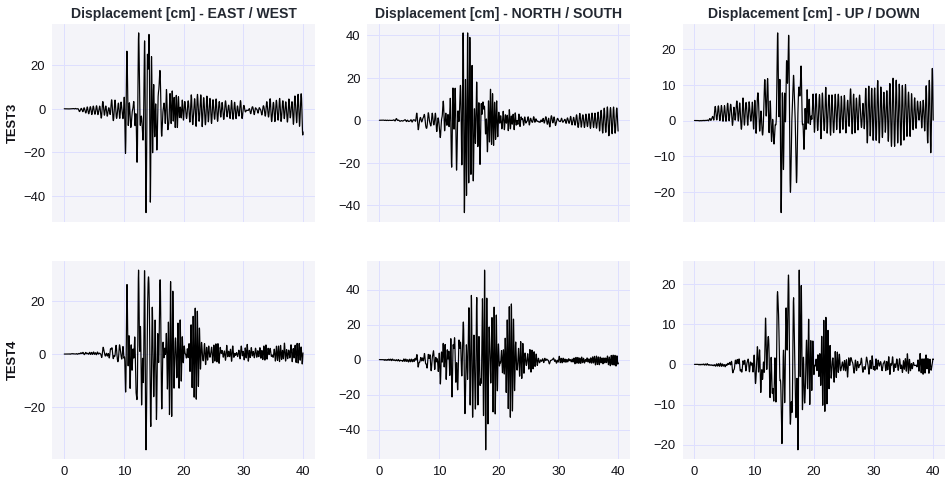

In [48]:
npoint = (7,0)
SITES = ['TEST3','TEST4']
# SITES = ['PTR0','RIOA','TB4A','ARIA']
fig, axs = plt.subplots(2, 3, figsize=(16,8),sharex=True,sharey=False)
for idx, site in enumerate(SITES):
    pgve=0
    pgvn=0
    pgvv=0
    pgae=0
    pgan=0
    pgav=0
    axs[idx,0].set_ylabel(site, weight="bold")
    signal = create_signal((npoint[0],npoint[1]),site)
    axs[idx,0].plot(np.linspace(0,40,2048),100*signal['ae'],alpha=1,c='black',lw=1.2)
    axs[idx,1].plot(np.linspace(0,40,2048),100*signal['an'],alpha=1,c='black',lw=1.2)
    axs[idx,2].plot(np.linspace(0,40,2048),100*signal['av'],alpha=1,c='black',lw=1.2)
    lowe, highe = axs[idx,0].get_ylim()
    lown, highn = axs[idx,1].get_ylim()
    lowv, highv = axs[idx,2].get_ylim()
    M0 = signal['m0']
    Mw = 2*np.log10(1.8*M0*10**7 )/3 - 10.7 
axs[0,0].set_title('Displacement [cm] - EAST / WEST',weight="bold")
axs[0,1].set_title('Displacement [cm] - NORTH / SOUTH',weight="bold")
axs[0,2].set_title('Displacement [cm] - UP / DOWN',weight="bold")
# axs[0,2].set_xlim((0,30))
# axs[11,0].set_xlabel('Time [s]',weight="bold")
# axs[11,1].set_xlabel('Time [s]',weight="bold")
# axs[11,2].set_xlabel('Time [s]',weight="bold")

In [7]:
fig.savefig('arkalochori_demo.pdf')

In [27]:
print(M0)

9.783502123204865e+17


In [92]:
1.75*0.6

1.05

In [22]:
signal = np.load('./arkalochori_test/TEST5_0.npz')

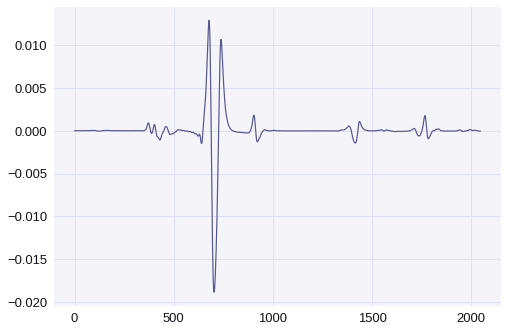

In [26]:
plt.plot(signal['vv'])

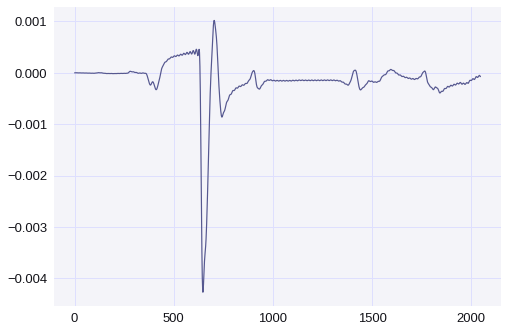

In [30]:
plt.plot(signal['de'])